In [1]:
import sys
import os
import glob
import random
import time
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

plt.style.use("dark_background")

In [2]:
! pip install gdown

In [3]:
!rm /kaggle/working/My_labeled_data/*

In [4]:
!gdown 12fjqiGnyIj5oKb0Ctg55DjvPkJnBkSIM

Downloading...
From: https://drive.google.com/uc?id=12fjqiGnyIj5oKb0Ctg55DjvPkJnBkSIM
To: /kaggle/working/data.zip
100%|███████████████████████████████████████| 3.08M/3.08M [00:00<00:00, 160MB/s]


In [5]:
!unzip -q /kaggle/working/data.zip -d /kaggle/working/My_labeled_data

In [6]:
!ls /kaggle/working/My_labeled_data -1 | wc -l

750


In [7]:
!gdown 1WJtBGjJyKplbf-SL-jMXnMnan41AlEY2

Downloading...
From (uriginal): https://drive.google.com/uc?id=1WJtBGjJyKplbf-SL-jMXnMnan41AlEY2
From (redirected): https://drive.google.com/uc?id=1WJtBGjJyKplbf-SL-jMXnMnan41AlEY2&confirm=t&uuid=fbad6ec3-816e-45a5-8807-cca275142f2a
To: /kaggle/working/data_all.zip
100%|█████████████████████████████████████████| 148M/148M [00:00<00:00, 237MB/s]


In [8]:
!mkdir new_data

mkdir: cannot create directory ‘new_data’: File exists


In [9]:
!unzip -q data_all.zip -d new_data

replace new_data/datasets/isles/mask/104_60.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(24)

In [3]:
# Path to all data
DATA_PATH = '/kaggle/working/new_data/datasets/isles/'
MY_DATA_PATH = '/kaggle/working/My_labeled_data'
BATCH_SIZE = 32
# img size
IMG_SIZE = 128
IMAGE_DATASET_PATH = os.path.join(DATA_PATH, "raw")
MASK_DATASET_PATH = os.path.join(DATA_PATH, "mask")
TEST_SPLIT = 0.1

In [4]:
all_imagePaths = sorted([os.path.join(IMAGE_DATASET_PATH, f) for f in os.listdir(IMAGE_DATASET_PATH)])
all_maskPaths = sorted([os.path.join(MASK_DATASET_PATH, f) for f in os.listdir(MASK_DATASET_PATH)])

my_imagePaths = sorted([os.path.join(MY_DATA_PATH, f) for f in os.listdir(MY_DATA_PATH) if 'mask' not in f and 'DIFF' in f])
my_maskPaths = sorted([os.path.join(MY_DATA_PATH, f) for f in os.listdir(MY_DATA_PATH) if 'mask.png' in f and 'DIFF' in f])

In [5]:
print(f'count of my images {len(my_imagePaths)}')
print(f'count of my masks {len(my_maskPaths)}')

count of my images 161
count of my masks 161


In [6]:
print(f'count of all images {len(all_imagePaths)}')
print(f'count of all masks {len(all_maskPaths)}')

count of all images 15659
count of all masks 15659


In [7]:
imagePaths = []
maskPaths = []

In [8]:
for i, mask_path in enumerate(all_maskPaths):
    mask = cv2.imread(mask_path)
    if (mask > 0).sum() > 0:
        imagePaths.append(all_imagePaths[i])
        maskPaths.append(mask_path)

In [9]:
print(f'count of images {len(imagePaths)}')
print(f'count of masks {len(maskPaths)}')

count of images 4819
count of masks 4819


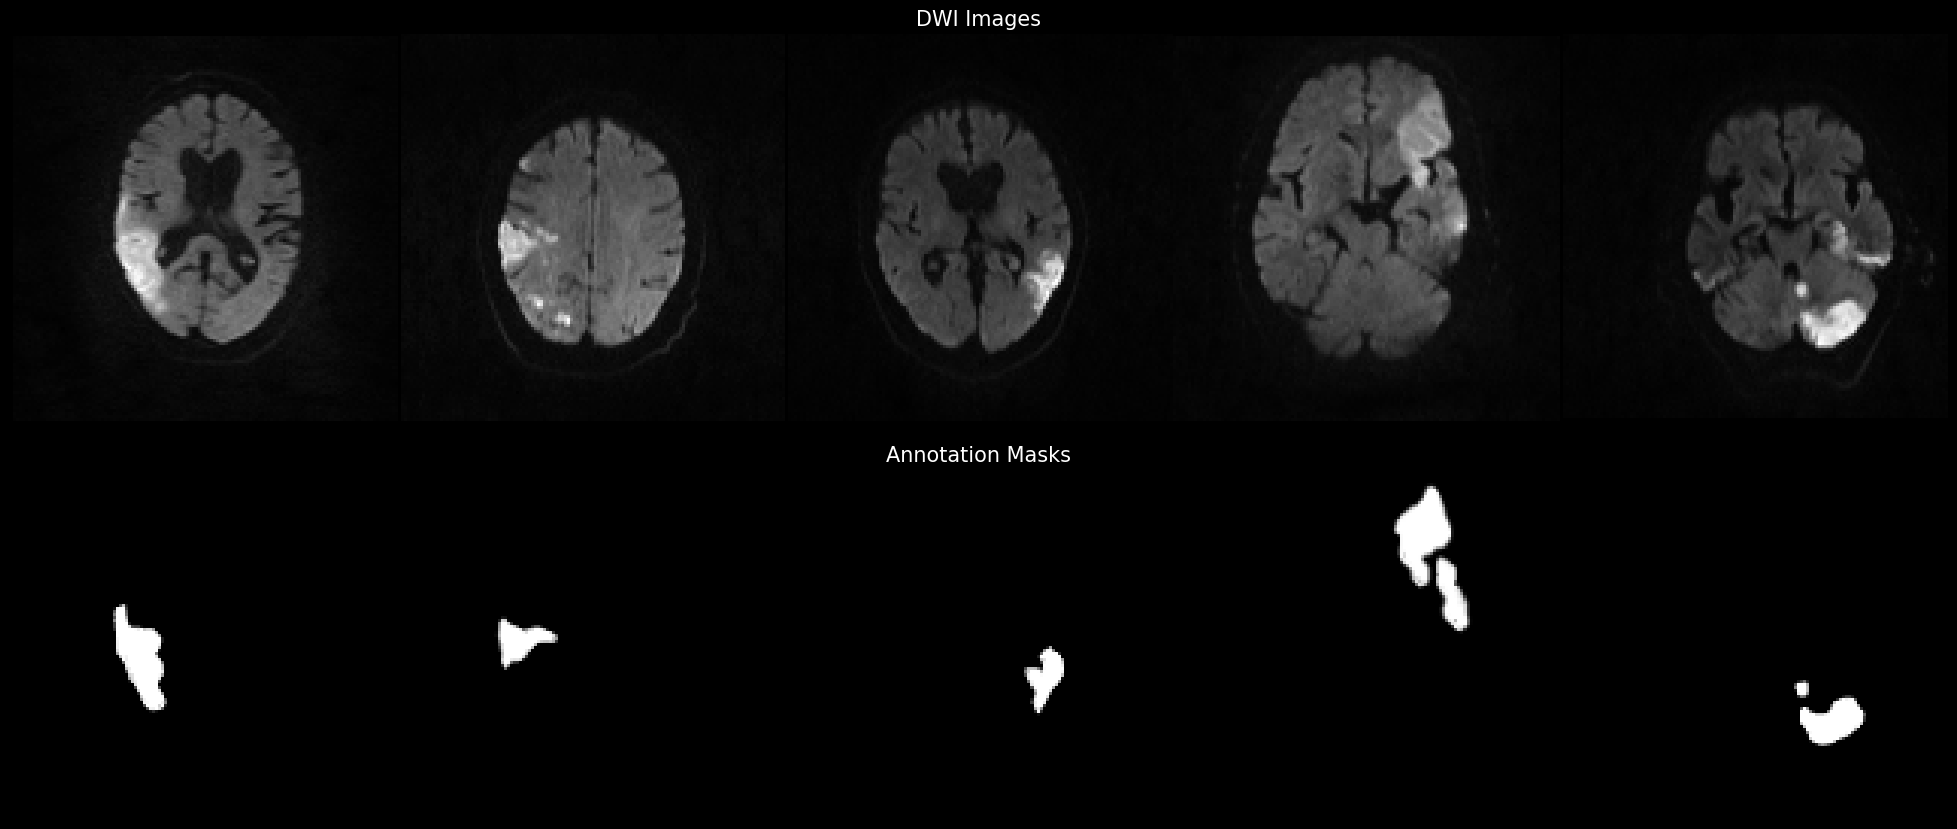

In [10]:
samples = random.sample(population=my_imagePaths, k=5)
sample_imgs = []

for s in samples:
    filename = s.split(os.path.sep)[-1]
    groundTruthPath = os.path.join(MY_DATA_PATH, f'{filename[:-4]}_mask.png')
    img = cv2.resize(cv2.imread(s), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(groundTruthPath), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])

sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_imgs_arr)
grid[0].set_title("DWI Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Annotation Masks", fontsize=15, y=0.9)
grid[1].axis("off")
plt.show()


In [11]:
!pip install albumentations==0.4.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65173 sha256=c7f63b35a24e22b43522b448ddb4ff692394f4133d7a314931f5dc16fa9e8e85
  Stored in directory: /root/.cache/pip/wheels/f9/d7/0c/6ed42fd872f7d1af78b25045f8b16be330f2c70ae72c83e37d
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.0
    Uninstalling albumentations-1.3.0:
      Successfully uninstalled albumentations-1.3.0


In [14]:
!pip freeze | grep scipy

scipy==1.10.1


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensor, ToTensorV2

from sklearn.model_selection import train_test_split

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
device

device(type='cuda')

In [15]:
class BrainMriDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transforms):
        
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        mask = cv2.imread(self.mask_paths[idx], 0)

        augmented = self.transforms(image=image, 
                                    mask=mask)
 
        image = augmented['image']
        mask = augmented['mask']   
        
        return image, mask
    
        # unnormilize mask
        #mask = torch.clamp(mask.float(), min=0, max=1)
        #mask = torch.ceil(mask)       

In [16]:
PATCH_SIZE = 128#256

strong_transforms = A.Compose([
    A.RandomResizedCrop(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    
    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
    A.IAAEmboss(p=0.25),
    A.Blur(p=0.01, blur_limit = 3),
    
    # Affine
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
    ], p=0.8),
    
    A.Normalize(p=1.0),
    #https://albumentations.readthedocs.io/en/latest/api/pytorch.html?highlight=ToTensor#albumentations.pytorch.transforms.ToTensor
    ToTensor(),
])


transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    
    A.Normalize(p=1.0),
    ToTensor(),
])

final_test_transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.Normalize(p=1.0),
    ToTensor(),
])

In [17]:
trainImages, testImages, trainMasks, testMasks = train_test_split(imagePaths, maskPaths, test_size=0.08, random_state=42)
trainImages, valImages, trainMasks, valMasks = train_test_split(trainImages, trainMasks, test_size=0.1, random_state=42)


#train_df = train_df[:1000]
print(f"Train: {len(trainImages)} \nVal: {len(valImages)} \nTest: {len(testImages)}")

Train: 3989 
Val: 444 
Test: 386


In [18]:
my_trainImages, my_testImages, my_trainMasks, my_testMasks = train_test_split(my_imagePaths, my_maskPaths, test_size=0.31, random_state=42)
my_trainImages, my_valImages, my_trainMasks, my_valMasks = train_test_split(my_trainImages, my_trainMasks, test_size=0.1, random_state=42)


#train_df = train_df[:1000]
print(f"Train: {len(my_trainImages)} \nVal: {len(my_valImages)} \nTest: {len(my_testImages)}")

Train: 99 
Val: 12 
Test: 50


In [19]:
[x.split('/')[-1] for x in my_testMasks]

['5175430_20230108_DIFF_00006221_mask.png',
 '5182256_20230112_DIFF_00004950_mask.png',
 '5198496_20230125_DIFF_00003826_mask.png',
 '5065797_20221013_DIFF_00004704_mask.png',
 '5172713_20230104_DIFF_00007782_mask.png',
 '4976755_20220727_DIFF_00002442_mask.png',
 '5175430_20230108_DIFF_00006217_mask.png',
 '5051118_20221001_DIFF_00005142_mask.png',
 '5172713_20230104_DIFF_00007788_mask.png',
 '5200543_20230126_DIFF_00002521_mask.png',
 '4918665_20220612_DIFF_00002306_mask.png',
 '5140631_20221213_DIFF_00005946_mask.png',
 '4902096_20220527_DIFF_00001371_mask.png',
 '5110309_20221117_DIFF_00004924_mask.png',
 '4929694_20220620_DIFF_00008078_mask.png',
 '4977585_20220728_DIFF_00002189_mask.png',
 '5193212_20230122_DIFF_00006883_mask.png',
 '5200555_20230126_DIFF_00001860_mask.png',
 '5172713_20230104_DIFF_00007786_mask.png',
 '4902096_20220527_DIFF_00001372_mask.png',
 '5110691_20221118_DIFF_00003698_mask.png',
 '4910382_20220603_DIFF_00001220_mask.png',
 '4876140_20220509_DIFF_00001236

In [20]:
# train
train_dataset = BrainMriDataset(image_paths=trainImages, mask_paths=trainMasks, transforms=strong_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)

# val
val_dataset = BrainMriDataset(image_paths=valImages, mask_paths=valMasks, transforms=strong_transforms)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

#test
test_dataset = BrainMriDataset(image_paths=testImages, mask_paths=testMasks, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

In [21]:
# train
my_train_dataset = BrainMriDataset(image_paths=my_trainImages, mask_paths=my_trainMasks, transforms=strong_transforms)
my_train_dataloader = DataLoader(my_train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)

# val
my_val_dataset = BrainMriDataset(image_paths=my_valImages, mask_paths=my_valMasks, transforms=strong_transforms)
my_val_dataloader = DataLoader(my_val_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

#test
my_test_dataset = BrainMriDataset(image_paths=my_testImages, mask_paths=my_testMasks, transforms=transforms)
my_test_dataloader = DataLoader(my_test_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

In [22]:
all_my_test_dataset = BrainMriDataset(image_paths=my_imagePaths, mask_paths=my_maskPaths, transforms=final_test_transforms)
all_my_test_dataloader = DataLoader(all_my_test_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

torch.Size([32, 3, 128, 128]) torch.Size([32, 1, 128, 128])


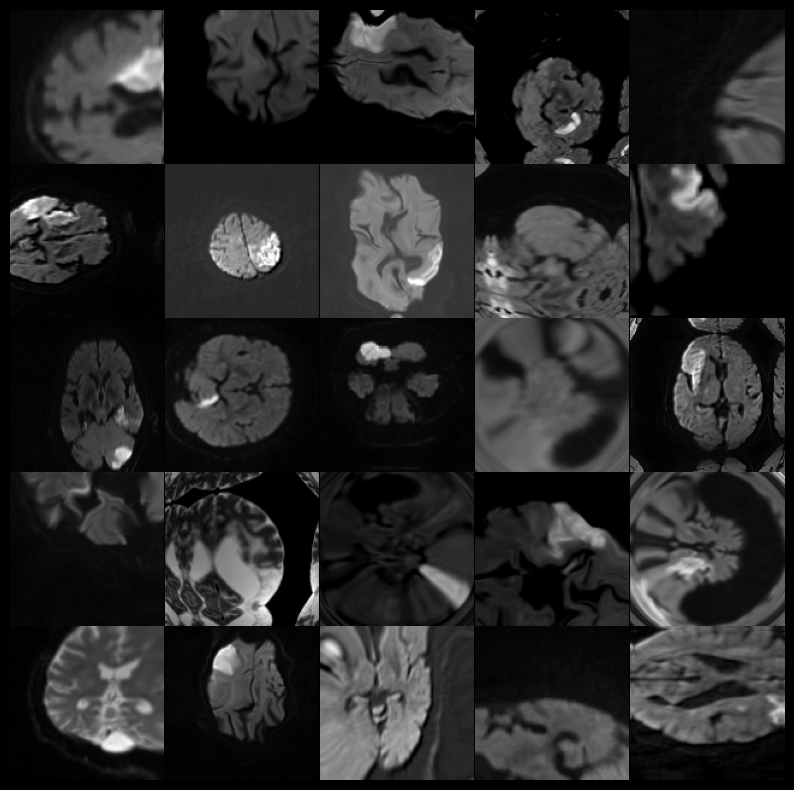

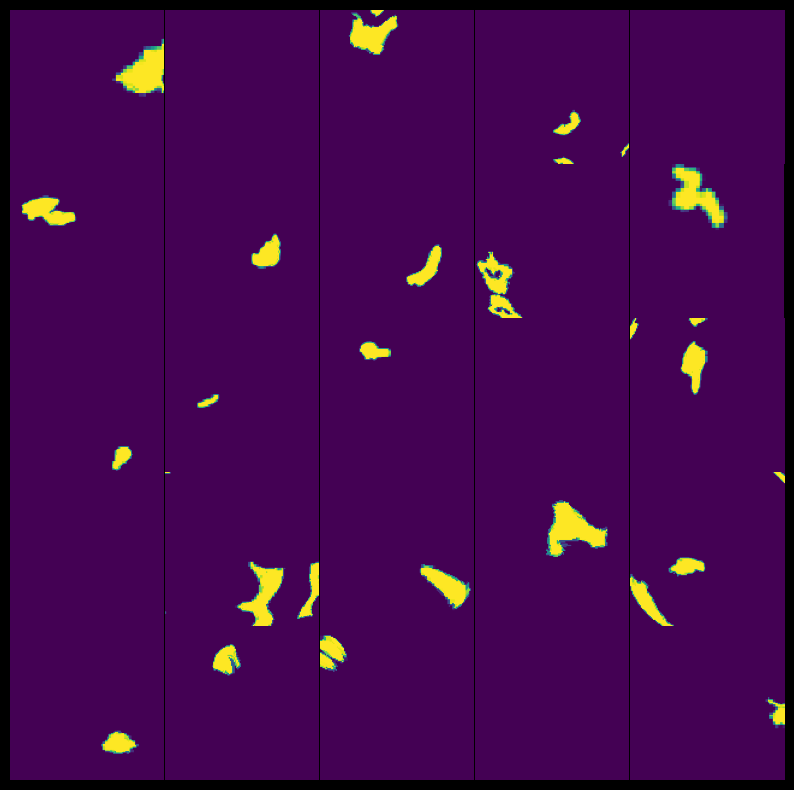

In [23]:
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if image is True:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        #plot
        #print(img.max(), len(np.unique(img)))
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

    
images, masks = next(iter(my_train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, image=False)

In [24]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))

In [25]:
class UNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
                
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.conv_up3 = double_conv(256 + 512, 256)
        self.conv_up2 = double_conv(128 + 256, 128)
        self.conv_up1 = double_conv(128 + 64, 64)
        
        self.last_conv = nn.Conv2d(64, n_classes, kernel_size=1)
        
        
    def forward(self, x):
        # Batch - 1d tensor.  N_channels - 1d tensor, IMG_SIZE - 2d tensor.
        # Example: x.shape >>> (10, 3, 256, 256).
        
        conv1 = self.conv_down1(x)  # <- BATCH, 3, IMG_SIZE  -> BATCH, 64, IMG_SIZE..
        x = self.maxpool(conv1)     # <- BATCH, 64, IMG_SIZE -> BATCH, 64, IMG_SIZE 2x down.
        conv2 = self.conv_down2(x)  # <- BATCH, 64, IMG_SIZE -> BATCH,128, IMG_SIZE.
        x = self.maxpool(conv2)     # <- BATCH, 128, IMG_SIZE -> BATCH, 128, IMG_SIZE 2x down.
        conv3 = self.conv_down3(x)  # <- BATCH, 128, IMG_SIZE -> BATCH, 256, IMG_SIZE.
        x = self.maxpool(conv3)     # <- BATCH, 256, IMG_SIZE -> BATCH, 256, IMG_SIZE 2x down.
        x = self.conv_down4(x)      # <- BATCH, 256, IMG_SIZE -> BATCH, 512, IMG_SIZE.
        x = self.upsample(x)        # <- BATCH, 512, IMG_SIZE -> BATCH, 512, IMG_SIZE 2x up.
        
        #(Below the same)                                 N this       ==        N this.  Because the first N is upsampled.
        x = torch.cat([x, conv3], dim=1) # <- BATCH, 512, IMG_SIZE & BATCH, 256, IMG_SIZE--> BATCH, 768, IMG_SIZE.
        
        x = self.conv_up3(x) #  <- BATCH, 768, IMG_SIZE --> BATCH, 256, IMG_SIZE. 
        x = self.upsample(x)  #  <- BATCH, 256, IMG_SIZE -> BATCH,  256, IMG_SIZE 2x up.   
        x = torch.cat([x, conv2], dim=1) # <- BATCH, 256,IMG_SIZE & BATCH, 128, IMG_SIZE --> BATCH, 384, IMG_SIZE.  

        x = self.conv_up2(x) # <- BATCH, 384, IMG_SIZE --> BATCH, 128 IMG_SIZE. 
        x = self.upsample(x)   # <- BATCH, 128, IMG_SIZE --> BATCH, 128, IMG_SIZE 2x up.     
        x = torch.cat([x, conv1], dim=1) # <- BATCH, 128, IMG_SIZE & BATCH, 64, IMG_SIZE --> BATCH, 192, IMG_SIZE.  
        
        x = self.conv_up1(x) # <- BATCH, 128, IMG_SIZE --> BATCH, 64, IMG_SIZE.
        
        out = self.last_conv(x) # <- BATCH, 64, IMG_SIZE --> BATCH, n_classes, IMG_SIZE.
        out = torch.sigmoid(out)
        
        return out

In [26]:
# unet = UNet(n_classes=1).to(device)

In [27]:
class ConvReluUpsample(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.make_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, (3, 3), stride=1, padding=1, bias=False
            ),
            nn.GroupNorm(32, out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.block(x)
        if self.upsample:
            x = self.make_upsample(x)
        return x



class SegmentationBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_upsamples=0):
        super().__init__()

        blocks = [ConvReluUpsample(in_channels, out_channels, upsample=bool(n_upsamples))]

        if n_upsamples > 1:
            for _ in range(1, n_upsamples):
                blocks.append(ConvReluUpsample(out_channels, out_channels, upsample=True))

        self.block = nn.Sequential(*blocks)

    def forward(self, x):
        return self.block(x)

In [28]:
class FPN(nn.Module):

    def __init__(self, n_classes=1, 
                 pyramid_channels=256, 
                 segmentation_channels=256):
        super().__init__()
         
        # Bottom-up layers
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)        
        self.conv_down5 = double_conv(512, 1024)   
        self.maxpool = nn.MaxPool2d(2)
        
        # Top layer
        self.toplayer = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)  # Reduce channels

        # Smooth layers
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        # Lateral layers
        self.latlayer1 = nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)
        
        # Segmentation block layers
        self.seg_blocks = nn.ModuleList([
            SegmentationBlock(pyramid_channels, segmentation_channels, n_upsamples=n_upsamples)
            for n_upsamples in [0, 1, 2, 3]
        ])
        
        # Last layer
        self.last_conv = nn.Conv2d(256, n_classes, kernel_size=1, stride=1, padding=0)
        
    def upsample_add(self, x, y):
        _,_,H,W = y.size()
        upsample = nn.Upsample(size=(H,W), mode='bilinear', align_corners=True) 
        
        return upsample(x) + y
    
    def upsample(self, x, h, w):
        sample = nn.Upsample(size=(h, w), mode='bilinear', align_corners=True)
        return sample(x)
        
    def forward(self, x):
        
        # Bottom-up
        c1 = self.maxpool(self.conv_down1(x))
        c2 = self.maxpool(self.conv_down2(c1))
        c3 = self.maxpool(self.conv_down3(c2))
        c4 = self.maxpool(self.conv_down4(c3))
        c5 = self.maxpool(self.conv_down5(c4)) 
        
        # Top-down
        p5 = self.toplayer(c5) 
        p4 = self.upsample_add(p5, self.latlayer1(c4)) 
        p3 = self.upsample_add(p4, self.latlayer2(c3))
        p2 = self.upsample_add(p3, self.latlayer3(c2)) 
        
        # Smooth
        p4 = self.smooth1(p4)
        p3 = self.smooth2(p3)
        p2 = self.smooth3(p2)
        
        # Segmentation
        _, _, h, w = p2.size()
        feature_pyramid = [seg_block(p) for seg_block, p in zip(self.seg_blocks, [p2, p3, p4, p5])]
        
        out = self.upsample(self.last_conv(sum(feature_pyramid)), 4 * h, 4 * w)
        
        out = torch.sigmoid(out)
        return out

In [29]:
# fpn = FPN().to(device)

In [30]:
from torchvision.models import resnext50_32x4d

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()

        self.convrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.convrelu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)
        
        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)
        
        self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)

        return x

In [31]:
class ResNeXtUNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        
        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]
        
        # Down
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        # Up
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)
                       
        
    def forward(self, x):
        # Down
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Up + sc
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        # final classifier
        out = self.last_conv0(d1)
        out = self.last_conv1(out)
        out = torch.sigmoid(out)
        
        return out


In [32]:
# rx50 = ResNeXtUNet(n_classes=1).to(device)
# rx50 = torch.load('/kaggle/working/ResNeXt50_v4.pth')
# rx50 = ResNeXtUNet(n_classes=1).to(device)
# rx50.load_state_dict(torch.load('/kaggle/working/ResNeXt50_v4.pth'))
# model.eval()

In [33]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0
    return intersection / union

# Metric check
dice_coef_metric(np.array([0., 0.9]), 
                 np.array([0., 1]))

0.9473684210526316

In [34]:
def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# loss check
bce_dice_loss(torch.tensor([0.7, 1., 1.]), 
              torch.tensor([1.,1.,1.]))



tensor(0.1637)

In [35]:
from sklearn.metrics import roc_curve, auc

def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):  
    
    print(model_name)
    loss_history = []
    train_history = []
    val_history = []
    best_model = None
    best_dice = 0
    
    if lr_scheduler:
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
#             warmup_factor = 1.0 / 100
#             warmup_iters = min(100, len(train_loader) - 1)
#             lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)
        
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        losses = []
        train_iou = []
                
      
        
        
        for i_step, (data, target) in enumerate(train_loader):
            
            data = data.to(device)
                      
            outputs = model(data)
            out_cut = outputs.detach().cpu().numpy()
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            train_dice = dice_coef_metric(out_cut, target.detach().cpu().numpy())
            target = target.to(device)
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
#             if i_step % 100 == 0:
#                 print(i_step, np.array(losses).mean())
            train_iou.append(train_dice)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
        if lr_scheduler:
            lr_scheduler.step()
 
        #torch.save(model.state_dict(), f'{model_name}_{str(epoch)}_epoch.pt')
        val_mean_iou = compute_iou(model, val_loader)
        
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_iou).mean(), 
              "\nMean DICE on validation:", val_mean_iou)
        
        if val_mean_iou > best_dice:
            best_model = model
            best_dice = val_mean_iou
            torch.save(best_model.state_dict(), f'{model_name}.pth')
            print('Saved!')
            
        
    return loss_history, train_history, val_history


def compute_iou(model, loader, threshold=0.3, auc_draw=False):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    valloss = 0
    precisions, recalls, f1s = [], [], []
    y_true_list = []
    y_pred_list = []
    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):
            
            data = data.to(device)
            target = target.to(device)
            #prediction = model(x_gpu)
            
            outputs = model(data)
            
            y_true_list.append(target)
            y_pred_list.append(outputs)

            model_output_bin = (outputs > threshold).float()
            ground_truth_bin = (target > 0.5).float()
            TP = torch.sum(model_output_bin * ground_truth_bin)
            FP = torch.sum(model_output_bin * (1 - ground_truth_bin))
            FN = torch.sum((1 - model_output_bin) * ground_truth_bin)
            precision = TP / (TP + FP + 1e-7) 
            recall = TP / (TP + FN + 1e-7)
            f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
            precisions.append(precision.item())
            recalls.append(recall.item())
            f1s.append(f1_score.item())
            
            out_cut = np.copy(outputs.detach().cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = dice_coef_metric(out_cut, ground_truth_bin.detach().cpu().numpy())
            valloss += picloss
    
    if auc_draw:
        all_y_true_flat =  np.array([])
        all_y_pred_flat =  np.array([])

        for i in range(len(y_true_list)):
            y_true = (y_true_list[i] > 0.5).float()
            y_pred = y_pred_list[i]
            
            y_true_np = y_true.cpu().numpy()
            y_pred_np = y_pred.cpu().numpy()

            y_true_flat = y_true_np.ravel()
            y_pred_flat = y_pred_np.ravel()
            all_y_true_flat = np.concatenate((all_y_true_flat, y_true_flat))
            all_y_pred_flat = np.concatenate((all_y_pred_flat, y_pred_flat))
        
        fpr, tpr, ths = roc_curve(all_y_true_flat, all_y_pred_flat)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = ths[optimal_idx]
        print(optimal_threshold)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()

        #print("Threshold:  " + str(threshold) + "  Validation DICE score:", valloss / i_step)
    print(f'precision: {np.array(precisions).mean()}\nrecall: {np.array(recalls).mean()}\nf1_score :{np.array(f1s).mean()}')
    return valloss / (i_step + 1)

In [36]:
# Optimizers
# unet_optimizer = torch.optim.Adamax(unet.parameters(), lr=1e-3)
# fpn_optimizer = torch.optim.Adamax(fpn.parameters(), lr=1e-3)
# rx50_optimizer = torch.optim.Adam(rx50.parameters(), lr=1e-3)

# lr_scheduler
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [37]:
# %%time
# num_ep = 10                                                                                                  
# Train UNet
# unet_lh, unet_th, unet_vh = train_model("Vanila_UNet", unet, train_dataloader, val_dataloader, bce_dice_loss, unet_optimizer, False, 20) 

#Train FPN
# fpn_lh, fpn_th, fpn_vh = train_model("FPN", fpn, train_dataloader, val_dataloader, bce_dice_loss, fpn_optimizer, True, 120)

# Train ResNeXt50
# rx50_lh, rx50_th, rx50_vh = train_model("ResNeXt50", rx50, train_dataloader, val_dataloader, bce_dice_loss, rx50_optimizer, False, num_ep)

In [38]:
# Train ResNeXt50
# rx50_lh, rx50_th, rx50_vh = train_model("ResNeXt50", rx50, train_dataloader, val_dataloader, bce_dice_loss, rx50_optimizer, True, num_epochs=150)

In [39]:
# Train FPN
# fpn_lh, fpn_th, fpn_vh = train_model("FPN", fpn, train_dataloader, val_dataloader, bce_dice_loss, fpn_optimizer, True, num_epochs=100)

In [40]:
import re

train_dice_pattern = r"Mean DICE on train: ([\d.]+)"
validation_dice_pattern = r"Mean DICE on validation: ([\d.]+)"

# Extract Mean DICE values from the text
train_dice_values = re.findall(train_dice_pattern, text)
validation_dice_values = re.findall(validation_dice_pattern, text)

train_dice_values = [float(value) for value in train_dice_values]
validation_dice_values = [float(value) for value in validation_dice_values]

NameError: name 'text' is not defined

In [43]:
len(train_dice_values), len(validation_dice_values)

NameError: name 'train_dice_values' is not defined

In [44]:
def plot_model_history(train_history, val_history,  train_loss, num_epochs):
    
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label=f'Train Dice Score', lw=3, c="lightcoral")
    plt.plot(x, val_history, label=f'Validation Dice Score', lw=3, c="palegreen")
#     plt.plot(x, train_loss, label=f'Train Loss', lw=3, c="skyblue")


#     plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Dice Score", fontsize=15)

    fn = str(int(time.time())) + ".png"
#     plt.show()
    plt.savefig('resnet_result.png', bbox_inches='tight', pad_inches=0.2)
    #plt.close()            

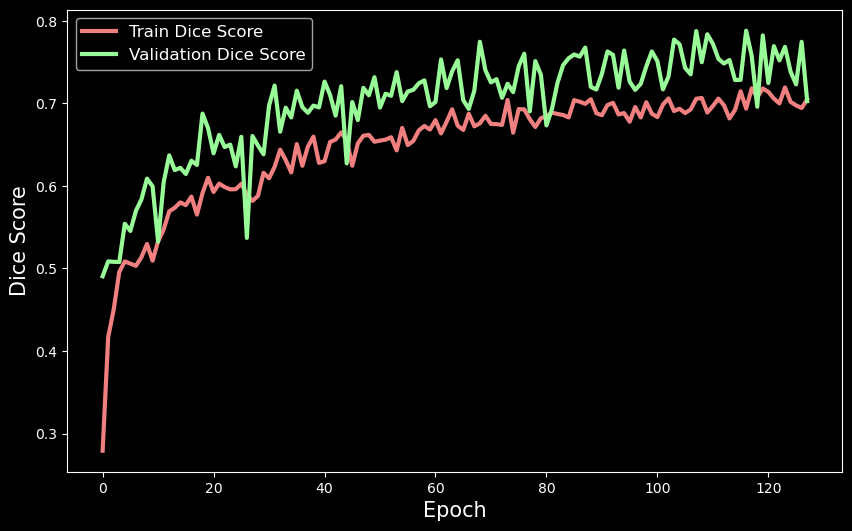

In [17]:
plot_model_history(train_dice_values, validation_dice_values, [], 128)

In [ ]:


#test_iou = compute_iou(unet, test_dataloader)
#print(f"""Vanilla UNet\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

#test_iou = compute_iou(fpn, test_dataloader)
#print(f"""FPN\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

# test_iou = compute_iou(rx50, test_dataloader)
# print(f"""ResNext50\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

In [ ]:
# the_model = ResNeXtUNet(n_classes=1)
# the_model.load_state_dict(torch.load('./resnet_model.pth'))
# the_model.to(device)

In [ ]:
# sample = random.sample(population=imagePaths, k=1)[0]
# filename = sample.split(os.path.sep)[-1]
# groundTruthPath = os.path.join(MASK_DATASET_PATH, filename)
# img = cv2.resize(cv2.imread(sample), (IMG_SIZE, IMG_SIZE))
# mask = cv2.resize(cv2.imread(groundTruthPath), (IMG_SIZE, IMG_SIZE))
# pred = torch.tensor(img.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
# pred = rx50(pred.to(device))
# pred = pred.detach().cpu().numpy()[0,0,:,:]

# # pred with tshd
# pred_t = np.copy(pred)
# pred_t[np.nonzero(pred_t < 0.3)] = 0.0
# pred_t[np.nonzero(pred_t >= 0.3)] = 255.#1.0
# pred_t = pred_t.astype("uint8")

# # plot
# fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

# ax[0, 0].imshow(img)
# ax[0, 0].set_title("image")
# ax[0, 1].imshow(mask)
# ax[0, 1].set_title("mask")
# ax[1, 0].imshow(pred)
# ax[1, 0].set_title("prediction")
# ax[1, 1].imshow(pred_t)
# ax[1, 1].set_title("prediction with threshold")
# plt.show()

In [ ]:
# sample = './datasets/test/59.jpg'
# img = cv2.resize(cv2.imread(sample), (IMG_SIZE, IMG_SIZE))
# pred = torch.tensor(img.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
# pred = rx50(pred.to(device))
# pred = pred.detach().cpu().numpy()[0,0,:,:]

# # pred with tshd
# pred_t = np.copy(pred)
# pred_t[np.nonzero(pred_t < 0.3)] = 0.0
# pred_t[np.nonzero(pred_t >= 0.3)] = 255.#1.0
# pred_t = pred_t.astype("uint8")

# # plot
# fig, ax = plt.subplots(nrows=1,  ncols=3, figsize=(10, 10))

# ax[0].imshow(img)
# ax[0].set_title("image")
# ax[1].imshow(pred)
# ax[1].set_title("prediction")
# ax[2].imshow(pred_t)
# ax[2].set_title("prediction with threshold")
# plt.show()

In [ ]:
# zooms = dwi.header.get_zooms()[:3]
# from functools import reduce
# voxel_size = reduce(lambda x, y: x*y, zooms)
# voxel_size

In [ ]:
# dwi_image = dwi.get_fdata()
# core_vlume = 0
# for j in range(5, dwi_image.shape[2] - 4):
#     sample = dwi_image[:,:,j, 1]
#     img = cv2.resize(sample, (IMG_SIZE, IMG_SIZE))
#     img = np.stack((img,)*3, axis=-1)
#     pred = torch.tensor(img.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
#     pred = rx50(pred.to(device))
#     pred = pred.detach().cpu().numpy()[0,0,:,:]

#     # pred with tshd
#     pred_t = np.copy(pred)
#     pred_t[np.nonzero(pred_t < 0.3)] = 0.0
#     pred_t[np.nonzero(pred_t >= 0.3)] = 255.#1.0
#     pred_t = pred_t.astype("uint8")

#     core = np.nonzero(pred_t)
#     core_vlume += len(core[0]) * voxel_size

#     # plot
#     fig, ax = plt.subplots(nrows=1,  ncols=2, figsize=(10, 10))

#     ax[0].imshow(sample, cmap='gray')
#     ax[0].set_title("image")
#     ax[1].imshow(pred_t)
#     ax[1].set_title("prediction")
#     # ax[2].imshow(pred_t)
#     # ax[2].set_title("prediction with threshold")
#     plt.show()
#     # img = plt.imshow(dwi_image[:,:,j], cmap='gray')
#     # plt.axis('off')
#     # plt.savefig(f'datasets/isles/raw/{j}.png',bbox_inches='tight',transparent=True, pad_inches=0)

In [ ]:
# core_vlume / (10 * 10 * 10)

In [ ]:
!gdown 1ysfqXyGB1zBLxm4n-5fYqFmh8v6Qlp7M

In [41]:
rx50 = ResNeXtUNet(n_classes=1)
rx50.load_state_dict(torch.load('/kaggle/working/ResNeXt50_test_v5.pth'))
rx50 = rx50.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 158MB/s] 


In [77]:
fpn = FPN().to(device)
fpn.load_state_dict(torch.load('/kaggle/working/FPN.pth'))
fpn = fpn.to(device)

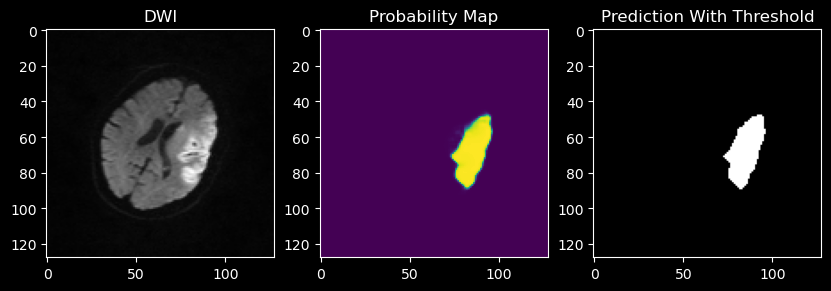

In [75]:
sample = random.sample(population=my_imagePaths, k=1)[0]
img = cv2.resize(cv2.imread(sample), (IMG_SIZE, IMG_SIZE))
pred = torch.tensor(img.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = rx50(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.#1.0
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=1,  ncols=3, figsize=(10, 10))

ax[0].imshow(img)
ax[0].set_title("DWI")
ax[1].imshow(pred)
ax[1].set_title("Probability Map")
ax[2].imshow(pred_t, cmap='gray')
ax[2].set_title("Prediction With Threshold")
plt.show()

In [45]:
test_path = '/kaggle/working/My_labeled_data'

In [40]:
test_imagePaths = sorted([os.path.join(test_path, f) for f in os.listdir(test_path) if f.endswith('.png')])

In [41]:
len(test_imagePaths) // 2

250

In [42]:
from PIL import Image, ImageOps, ImageEnhance

def increase_contrast(image, enhancement_factor=1.2):
    if image.mode != 'L':
        image = image.convert('L')

#     na = np.array(image)
#     print(f'DEBUG: Min grey: {na.min()}, max grey: {na.max()}')

#     # Get low (say 1%) and high (say 95%) percentiles
#     loPct, hiPct = 30.0, 70.0
#     loVal, hiVal = np.percentile(na, [loPct, hiPct])
#     print(f'DEBUG: {loPct} percentile={loVal}, {hiPct} percentile={hiVal}')

#     # Scale image pixels from range loVal..hiVal to range 0..255
#     res = ((na - na.min()) * 255.0 / (na.max() - na.min())).astype(np.uint8)
#     res = np.array(Image.fromarray(res))
#     return cv2.cvtColor(res,cv2.COLOR_GRAY2RGB)

    enhancer = ImageEnhance.Contrast(image)
    im_output = enhancer.enhance(enhancement_factor)
    res = np.array(im_output)
    return cv2.cvtColor(res,cv2.COLOR_GRAY2RGB)

In [48]:
def calculate_mean_dice_score(model, test_image_loader):
    model.eval()
    num_images = len(test_image_loader)
    total_dice_score = 0

    with torch.no_grad():
        for data, target in test_image_loader:
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)
            out_cut = np.copy(outputs.detach().cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            dice_score = dice_coef_metric(out_cut, target.detach().cpu().numpy())
            print(f'dice score {dice_score}')
            total_dice_score += dice_score
            
            for image, pred, mask in zip (data.detach().cpu().numpy(), out_cut, target.detach().cpu().numpy()):
                fig, ax = plt.subplots(nrows=1,  ncols=3, figsize=(10, 10))
                ax[0].imshow(image.T)
                ax[0].set_title("image")
                ax[1].imshow(pred.T, cmap='gray')
                ax[1].set_title("prediction")
                ax[2].imshow(mask.T, cmap='gray')
                ax[2].set_title("mask")
                plt.show()

    mean_dice_score = total_dice_score / num_images
    return mean_dice_score

dice score 0.7463411744092439


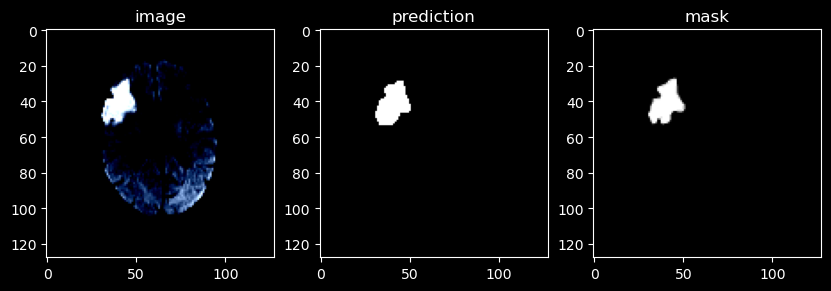

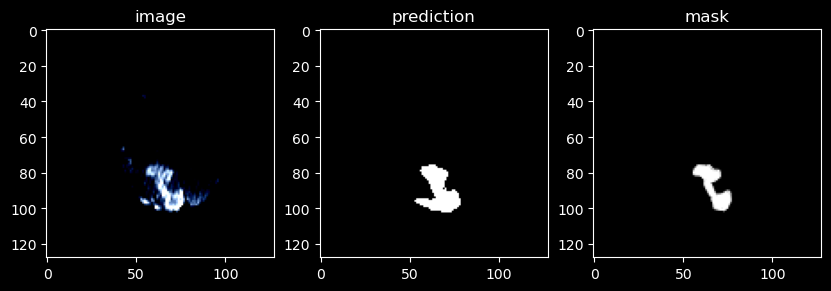

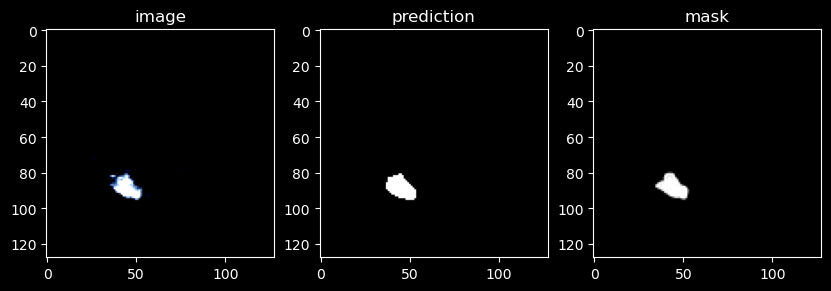

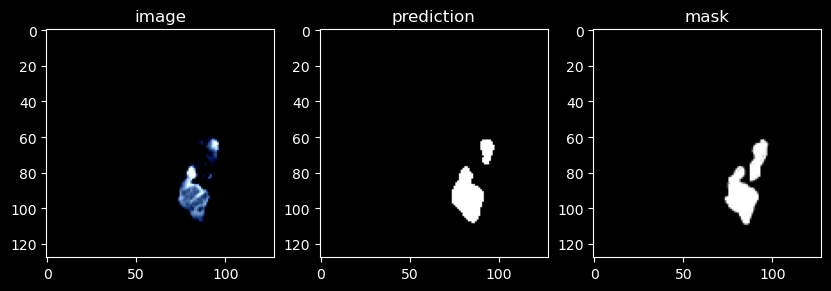

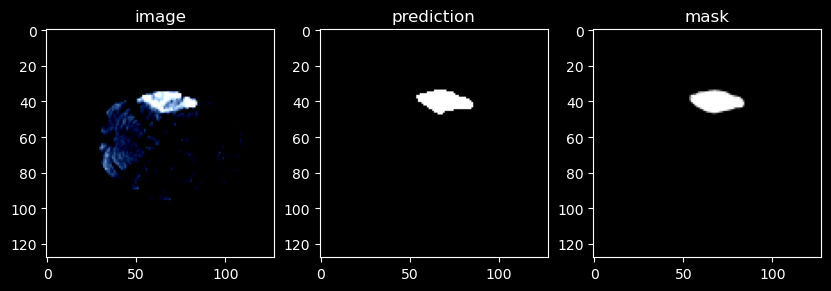

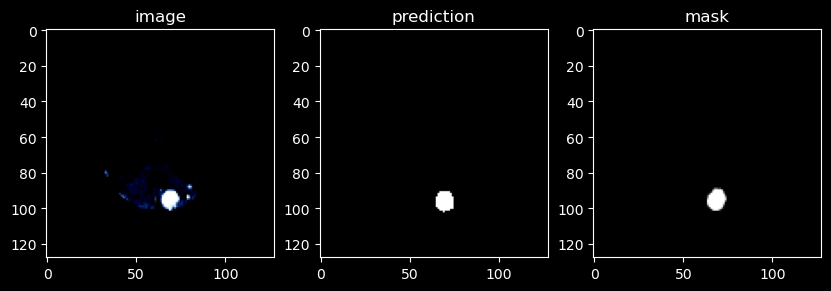

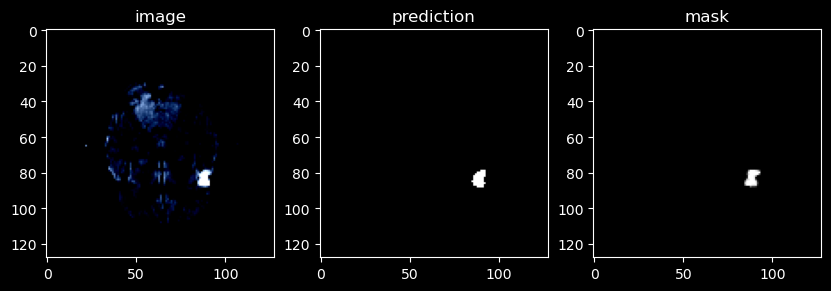

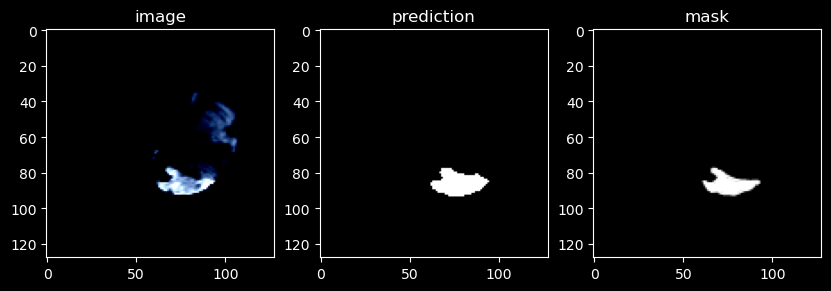

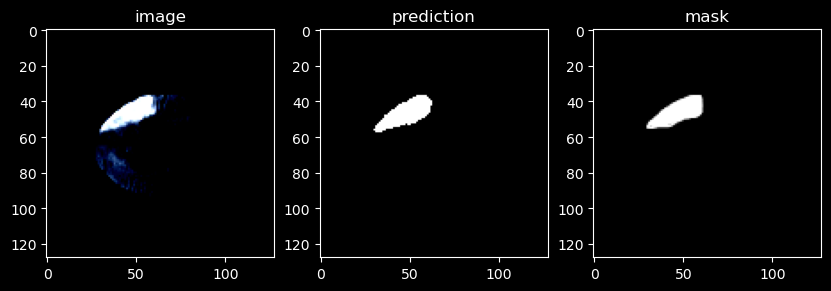

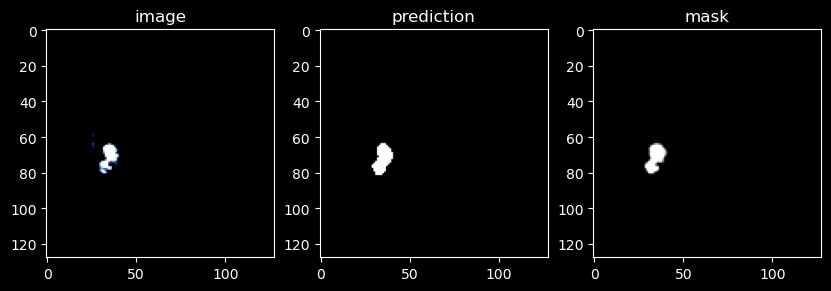

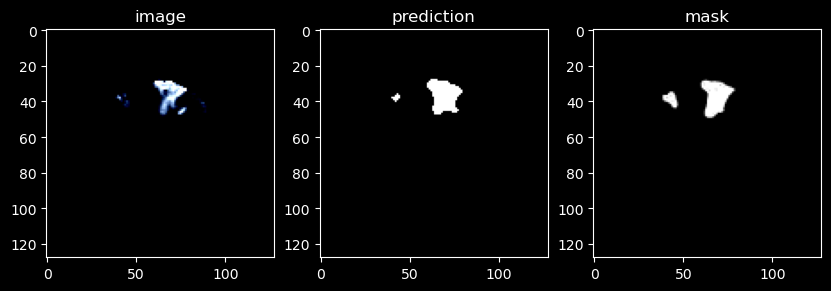

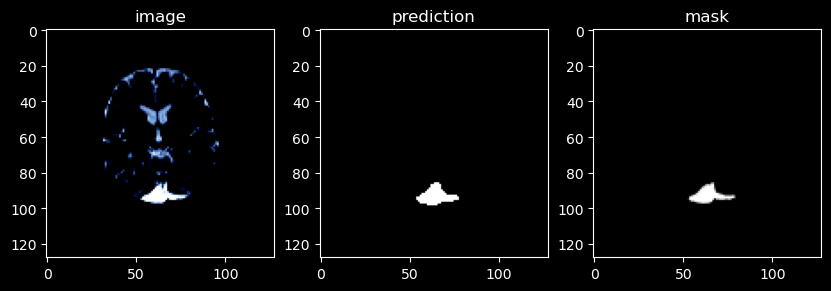

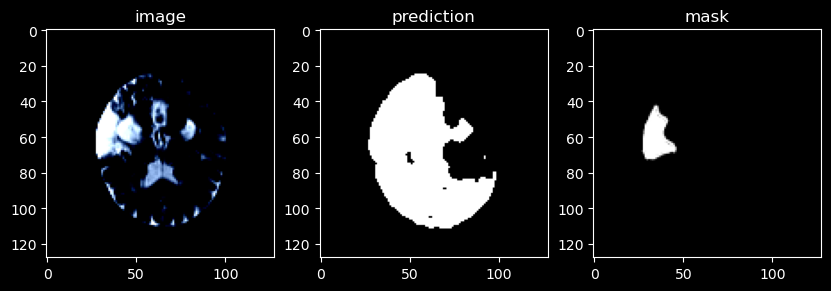

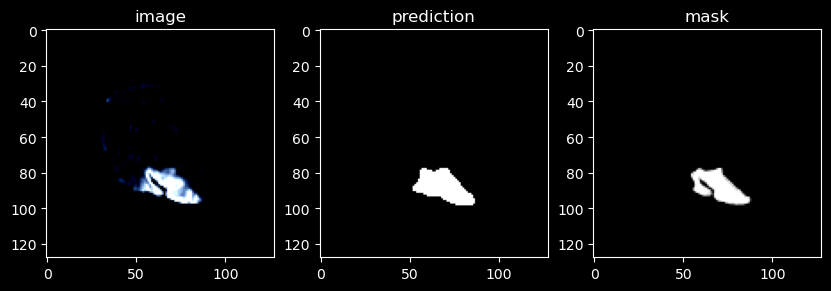

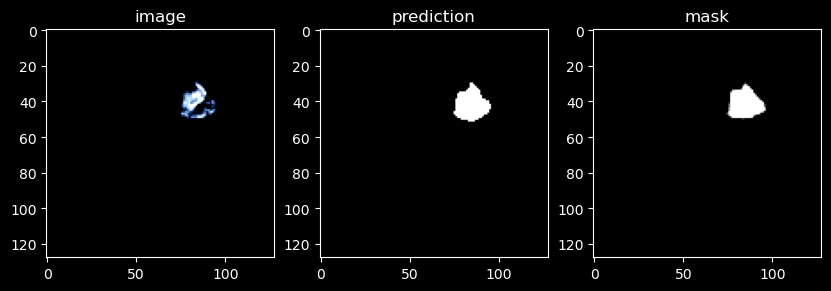

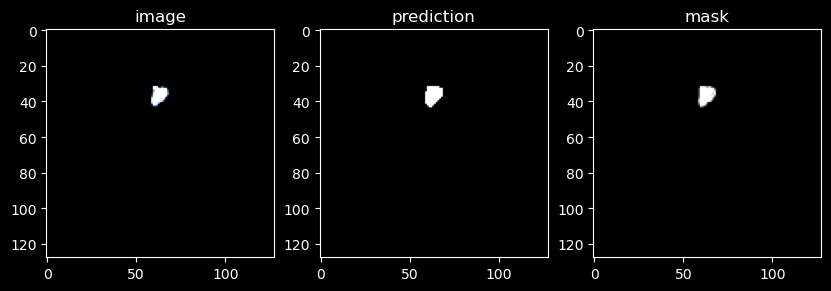

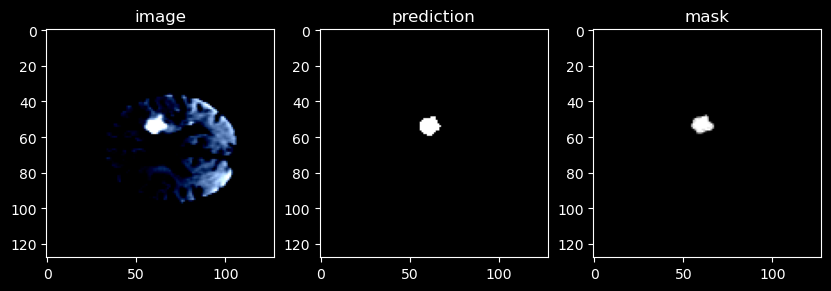

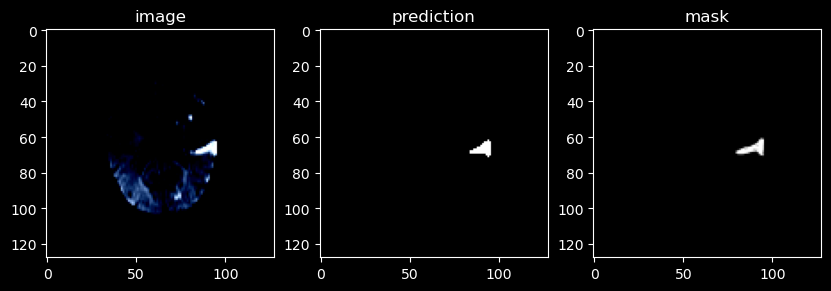

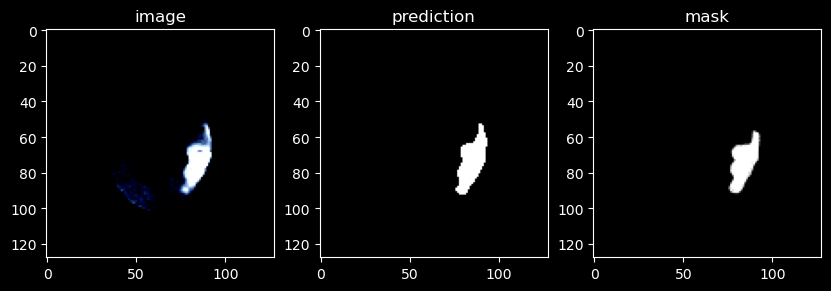

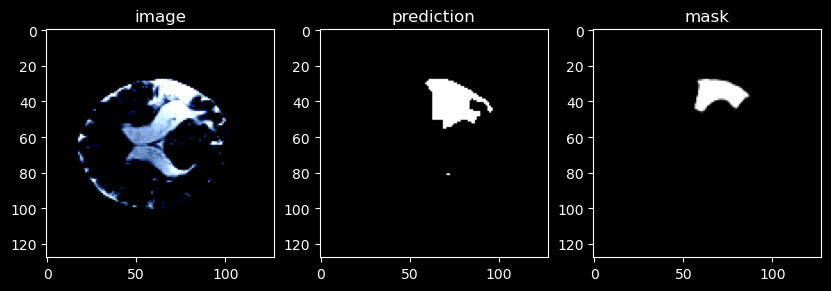

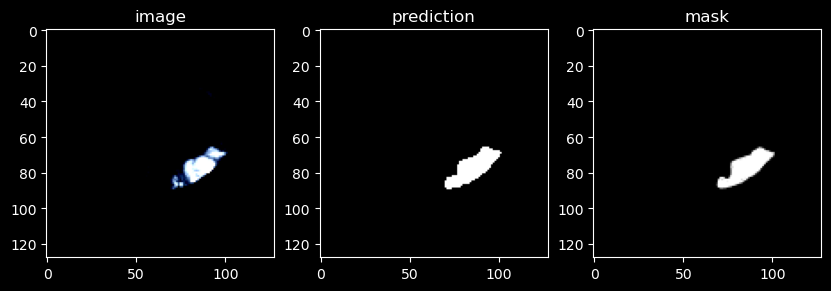

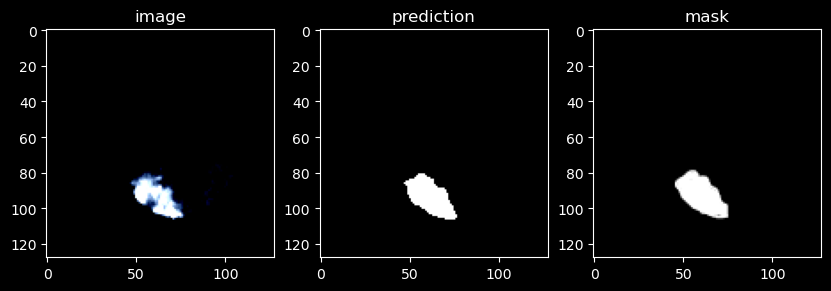

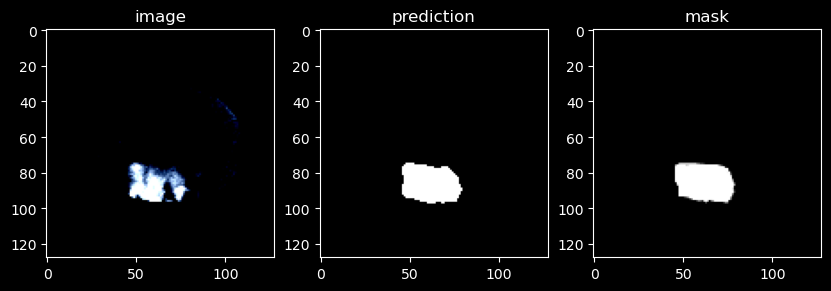

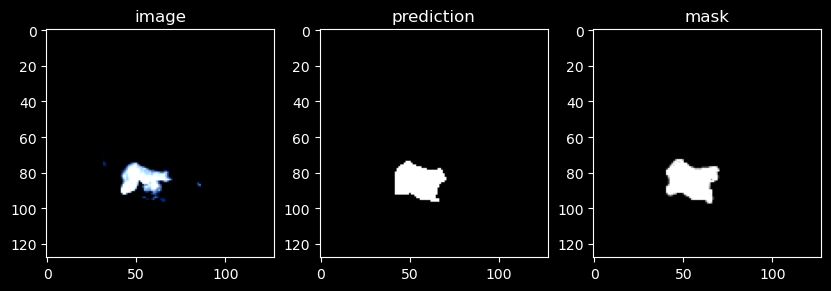

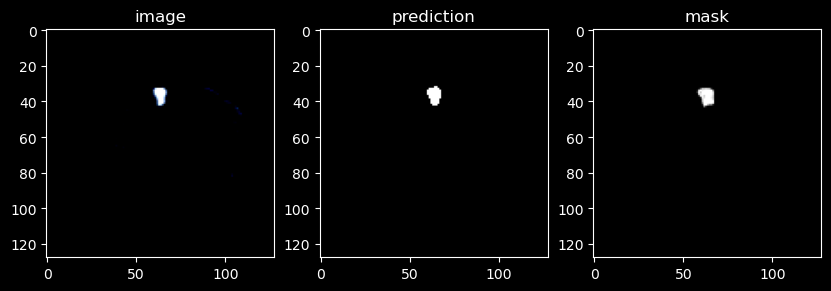

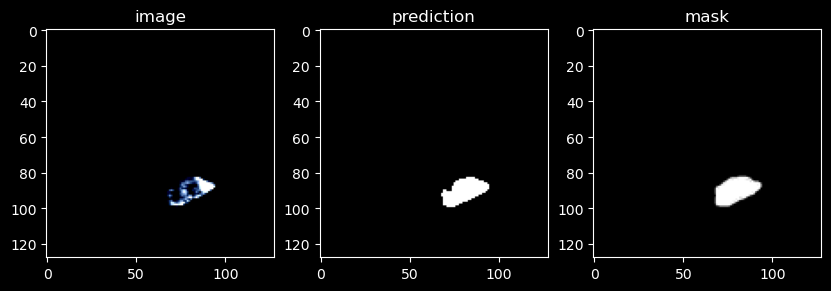

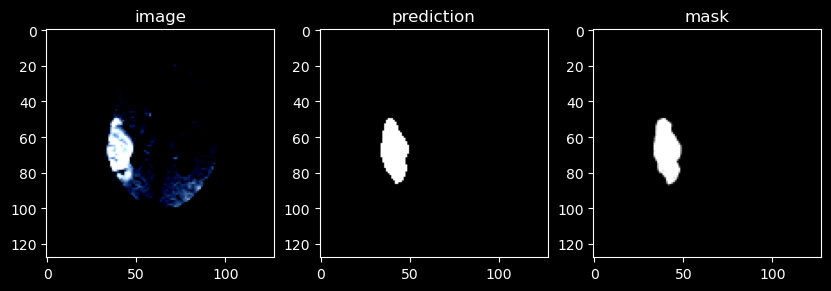

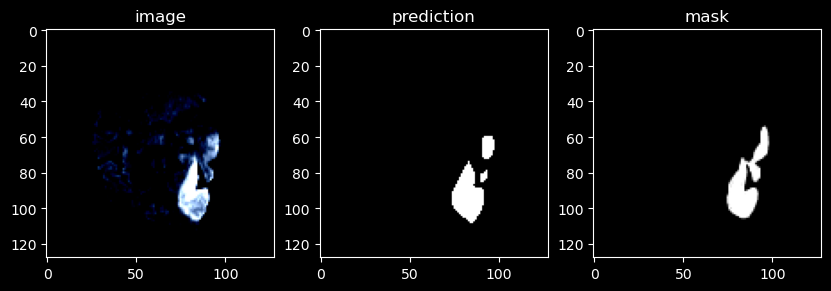

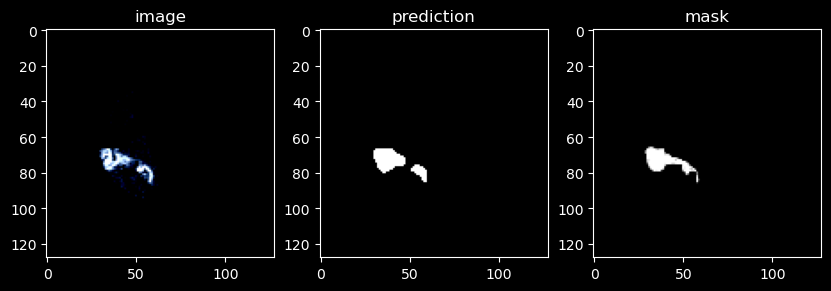

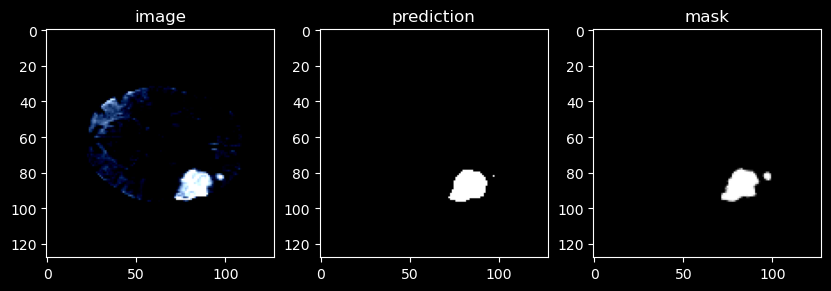

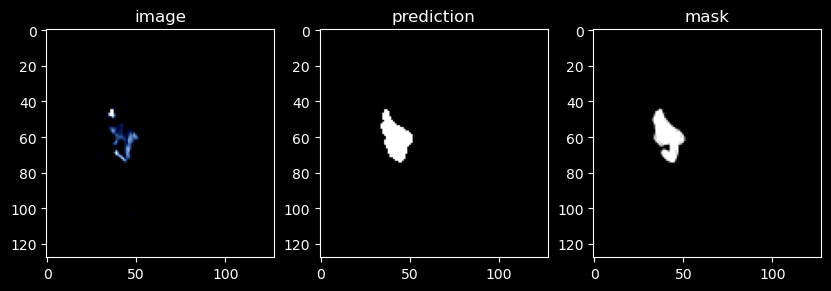

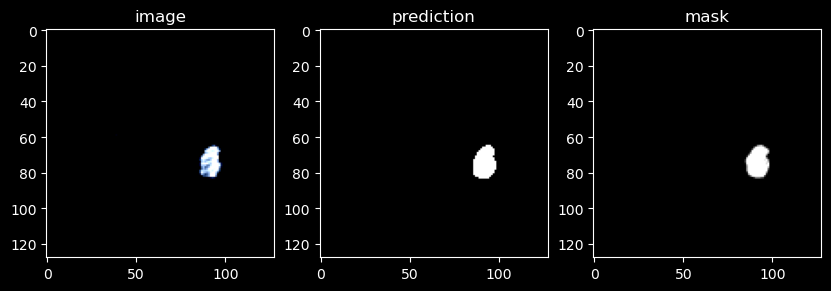

dice score 0.8478545931257631


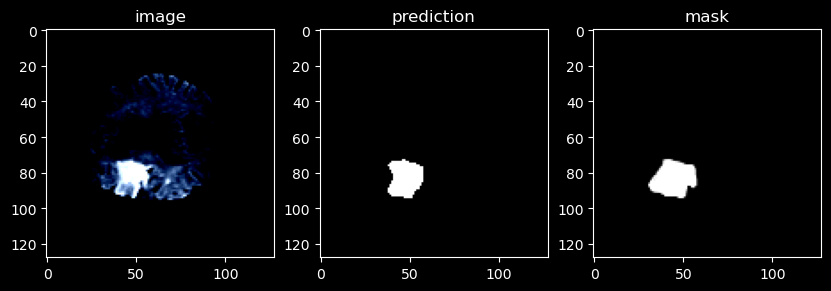

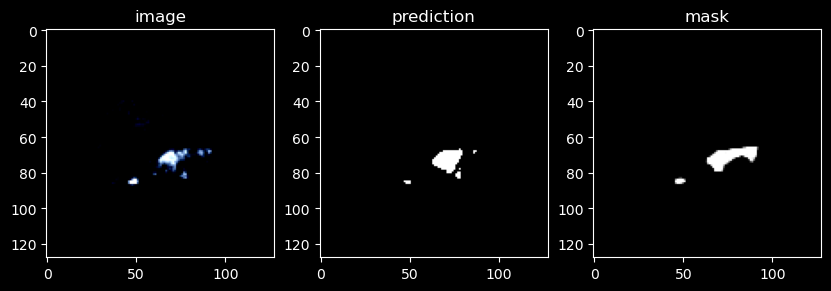

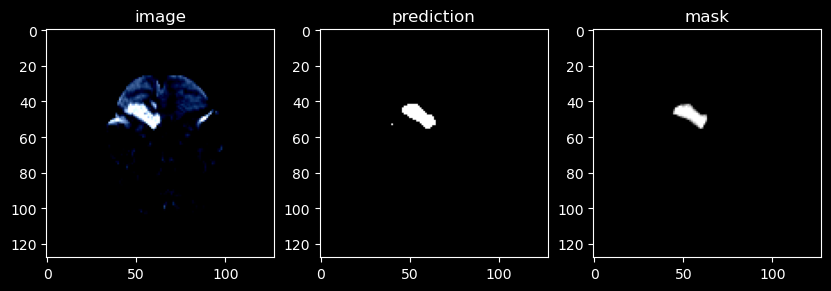

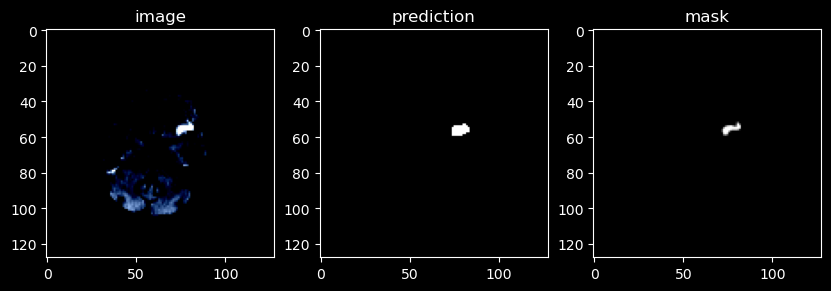

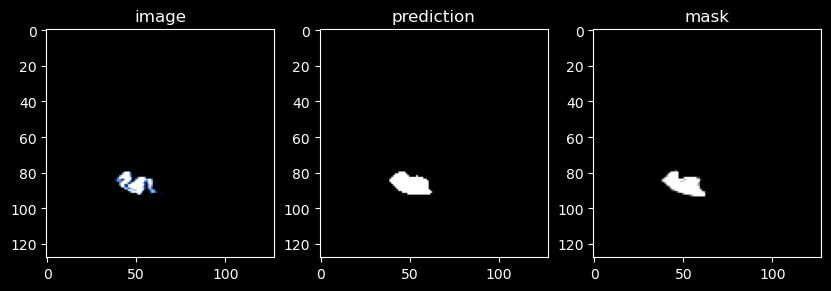

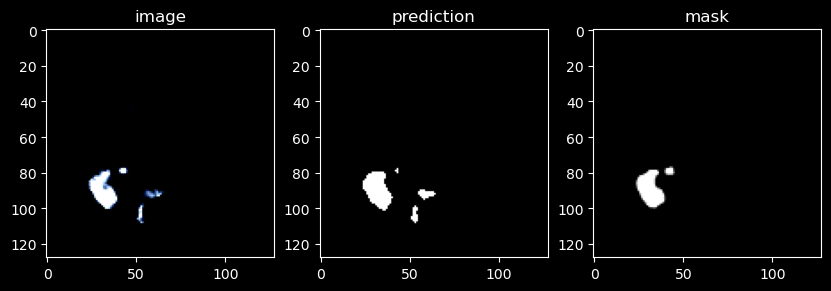

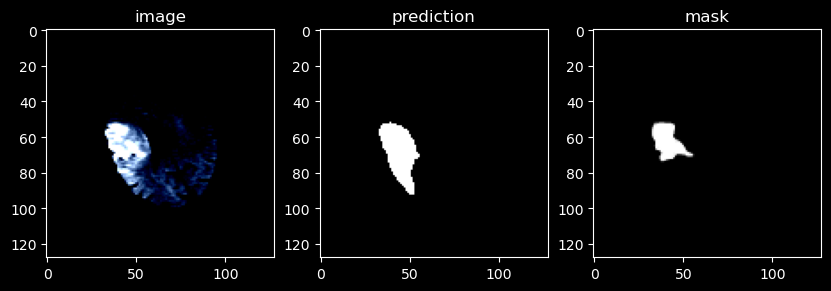

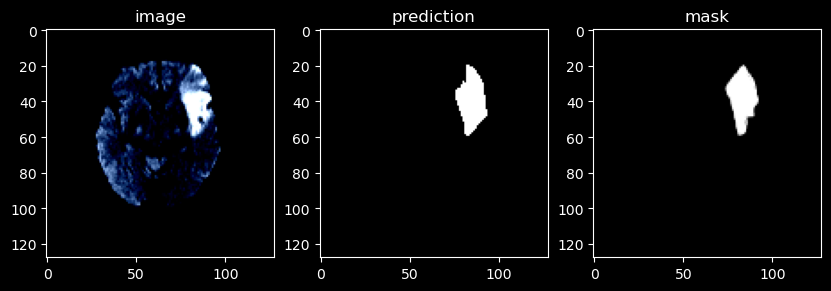

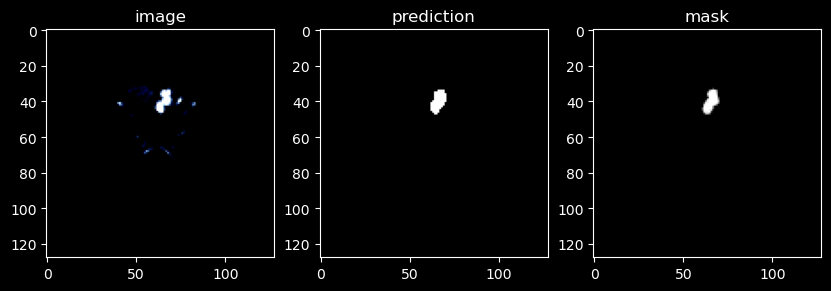

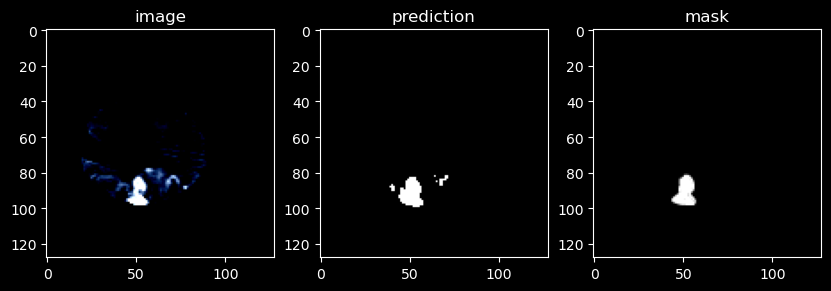

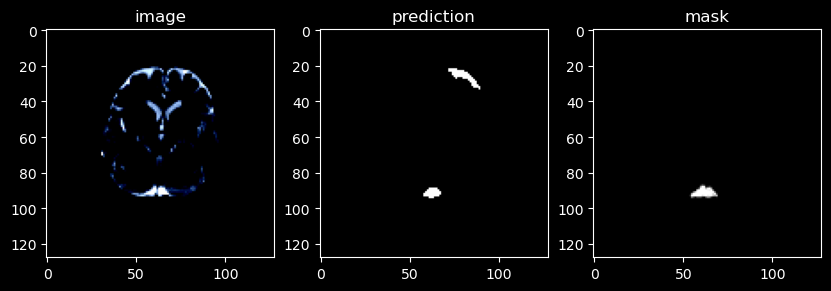

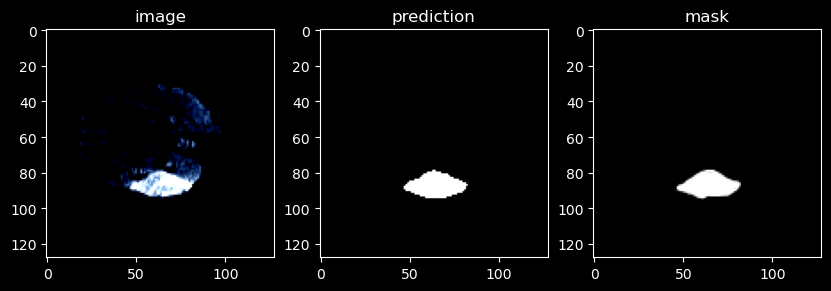

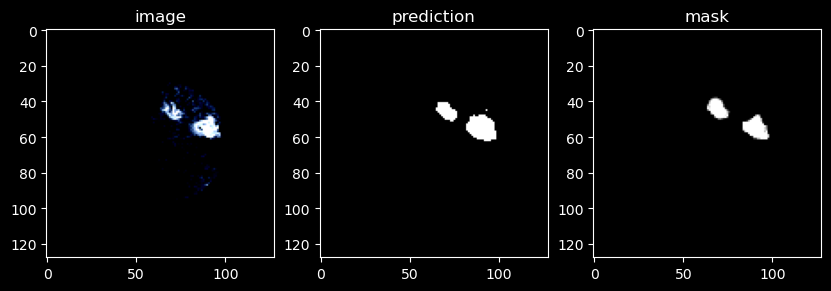

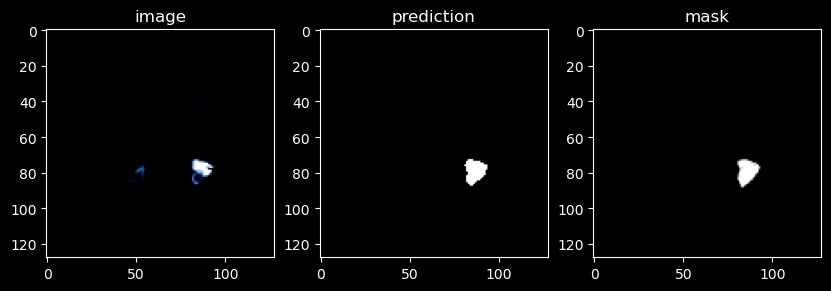

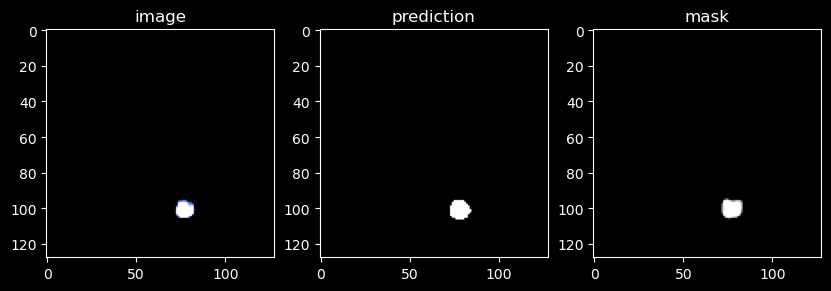

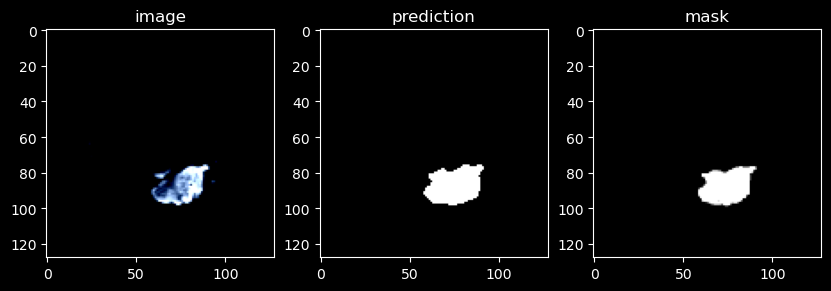

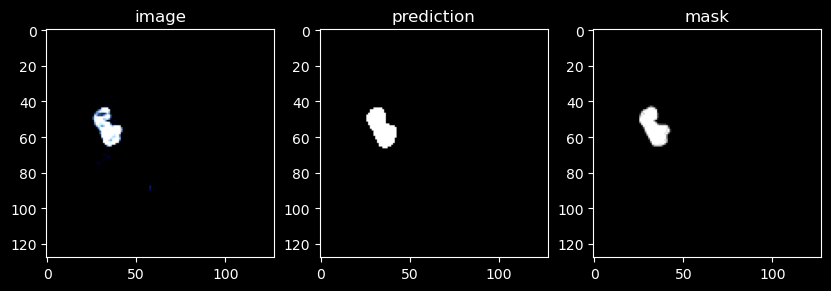

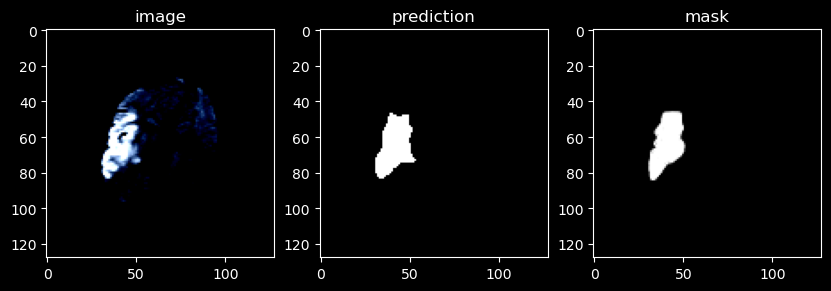

0.7970978837675035

In [49]:
calculate_mean_dice_score(rx50, my_test_dataloader)

In [44]:
my_testImages[0]

'/kaggle/working/My_labeled_data/5051118_20221001_DIFF_00005144.png'

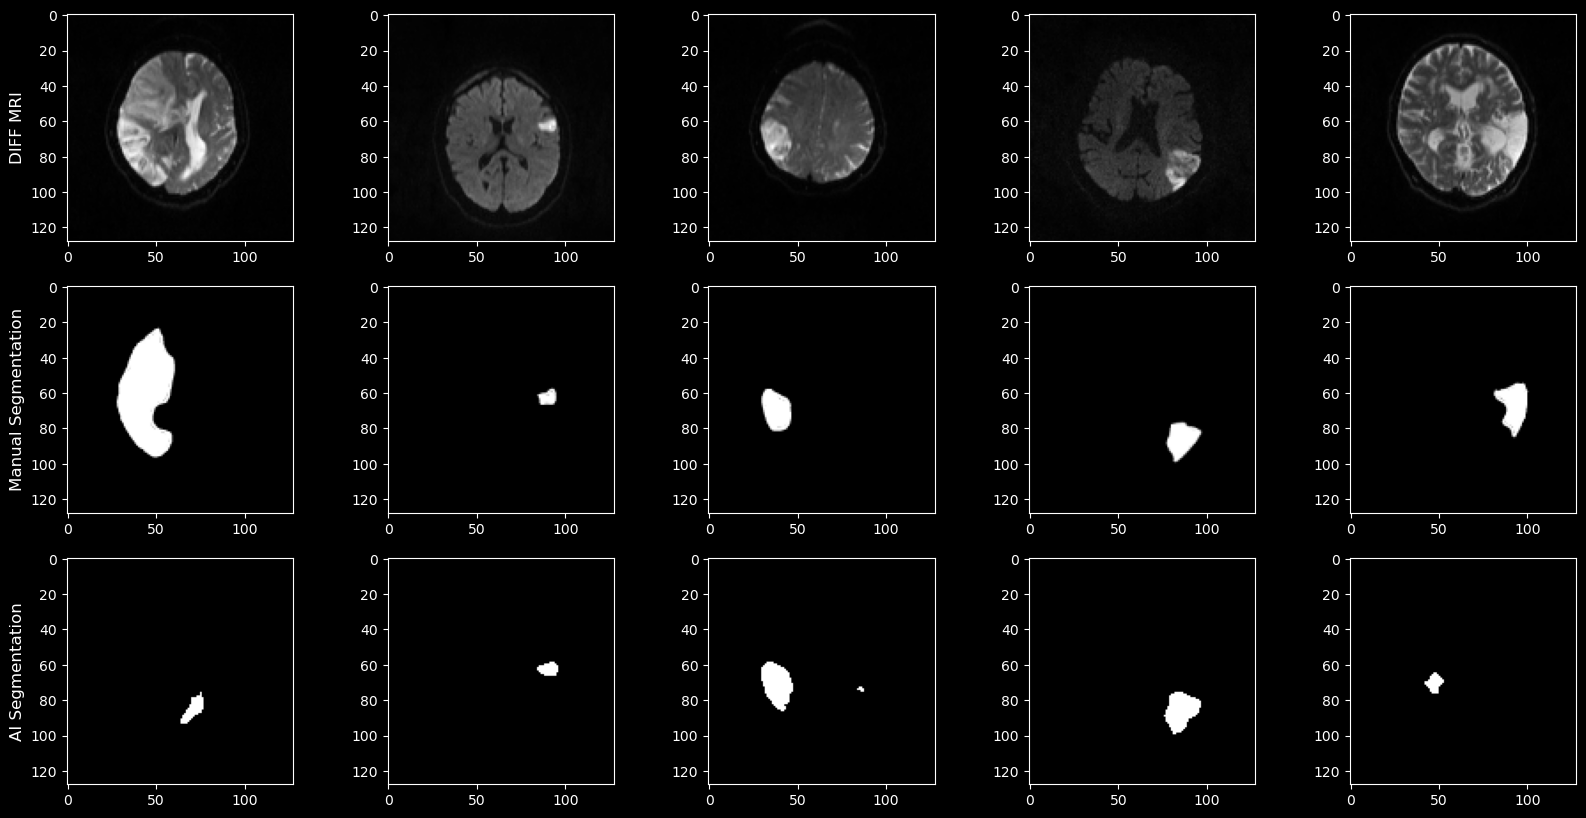

In [42]:
from PIL import Image

sample = random.sample(population=my_testImages, k=5)
fig, ax = plt.subplots(nrows=3,  ncols=5, figsize=(20, 10))

rows = ['DIFF MRI', 'Manual Segmentation', 'AI Segmentation']

for a, row in zip(ax[:,0], rows):
    a.set_ylabel(row, rotation=90, size='large')

for i, s in enumerate(sample):
    mask_path = '/'.join(s.split('/')[:-1]) + '/' + s.split('/')[-1][:-4] + '_mask.png'
    mask = cv2.resize(cv2.imread(mask_path), (IMG_SIZE, IMG_SIZE))
    p_img = cv2.resize(cv2.imread(s), (IMG_SIZE, IMG_SIZE))
    img = final_test_transforms(image=p_img)['image'].unsqueeze(0)
#     pred = torch.tensor(img.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
    pred = rx50(img.to(device))
    pred = pred.detach().cpu().numpy()[0,0,:,:]

    # pred with tshd
    pred_t = np.copy(pred)
    pred_t[np.nonzero(pred_t < 0.2)] = 0.0
    pred_t[np.nonzero(pred_t >= 0.2)] = 255.#1.0
    pred_t = pred_t.astype("uint8")

    # plot

    ax[0][i].imshow(p_img)
#     ax[0][i].set_title("image")
    ax[1][i].imshow(mask)
#     ax[1][i].set_title("prediction")
    ax[2][i].imshow(pred_t, cmap='gray')
#     ax[2][i].set_title("prediction with threshold")
plt.savefig('result.png')

In [107]:
rx50_optimizer = torch.optim.Adam(rx50.parameters(), lr=1e-3)

In [108]:
rx50_lh, rx50_th, rx50_vh = train_model("ResNeXt50_test_v5", rx50, my_train_dataloader, my_val_dataloader, bce_dice_loss, rx50_optimizer, True, num_epochs=45)

ResNeXt50_test_v5
precision: 0.6754447221755981
recall: 0.5835837721824646
f1_score :0.6261630058288574
Epoch [0]
Mean loss on train: 0.43173861503601074 
Mean DICE on train: 0.686291161418243 
Mean DICE on validation: 0.6261630584983878
Saved!
precision: 0.7084004878997803
recall: 0.6382654309272766
f1_score :0.6715065836906433
Epoch [1]
Mean loss on train: 0.352018266916275 
Mean DICE on train: 0.7608521623561372 
Mean DICE on validation: 0.6715066294753735
Saved!
precision: 0.7455755472183228
recall: 0.7653071284294128
f1_score :0.7553125023841858
Epoch [2]
Mean loss on train: 0.3500509212414424 
Mean DICE on train: 0.7543546430091325 
Mean DICE on validation: 0.755312507803331
Saved!
precision: 0.6483033299446106
recall: 0.7913071513175964
f1_score :0.7127025127410889
Epoch [3]
Mean loss on train: 0.3073290040095647 
Mean DICE on train: 0.7726943522140255 
Mean DICE on validation: 0.7127025704499007
precision: 0.8715589046478271
recall: 0.6264925003051758
f1_score :0.72898042201995

In [51]:
# fpn_optimizer = torch.optim.Adam(fpn.parameters(), lr=5e-4)

In [52]:
# fpn_lh, fpn_th, fpn_vh = train_model("FPN_test_v5", fpn, my_train_dataloader, my_val_dataloader, bce_dice_loss, fpn_optimizer, True, num_epochs=45)

FPN_test_v5
precision: 0.8376068472862244
recall: 0.22098734974861145
f1_score :0.34970998764038086
Epoch [0]
Mean loss on train: 0.7740424027045568 
Mean DICE on train: 0.4722053233261024 
Mean DICE on validation: 0.39155990912302285
Saved!
precision: 0.7780808806419373
recall: 0.6705509424209595
f1_score :0.7203249931335449
Epoch [1]
Mean loss on train: 0.5651897639036179 
Mean DICE on train: 0.5933561720607029 
Mean DICE on validation: 0.7343543748205195
Saved!
precision: 0.8625640869140625
recall: 0.559570848941803
f1_score :0.678790271282196
Epoch [2]
Mean loss on train: 0.5262431999047598 
Mean DICE on train: 0.6240736240062797 
Mean DICE on validation: 0.7113499763177881
precision: 0.6309034824371338
recall: 0.6611674427986145
f1_score :0.6456810235977173
Epoch [3]
Mean loss on train: 0.4947522282600403 
Mean DICE on train: 0.6368334955491518 
Mean DICE on validation: 0.6331533076396317
precision: 0.6730610132217407
recall: 0.6806390285491943
f1_score :0.6768287420272827
Epoch [

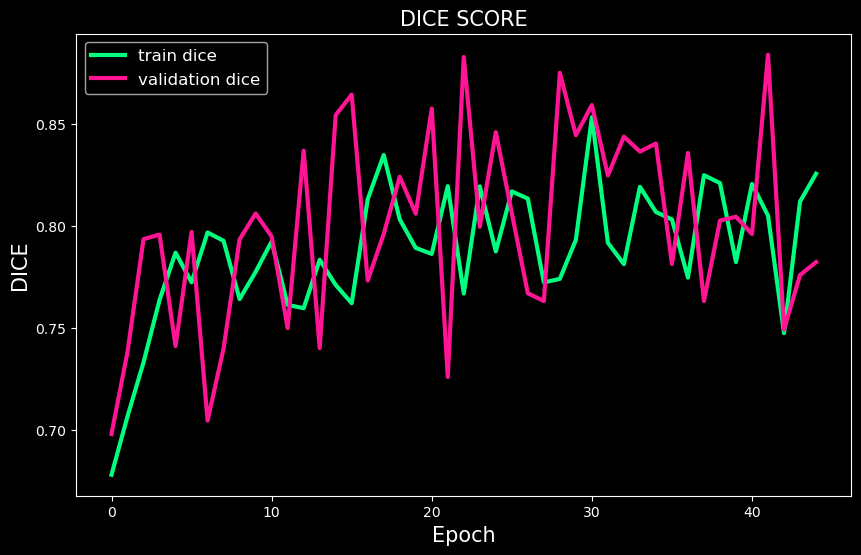

In [52]:
plot_model_history("DICE SCORE", rx50_th, rx50_vh, 45)

0.008973199874162674


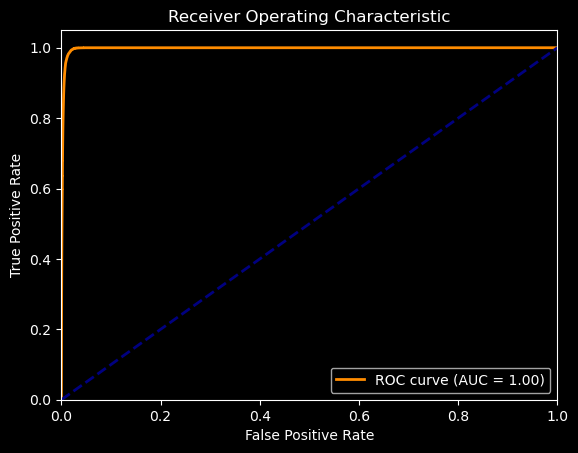

precision: 0.7180694341659546
recall: 0.9224229454994202
f1_score :0.8050406575202942
ResNeXt50_test
Mean IoU of the test images - 81.0%


In [47]:
test_iou = compute_iou(rx50, my_test_dataloader,threshold=0.3, auc_draw=True)
print(f"""ResNeXt50_test\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")